In [61]:
# %pip uninstall boardlib
%pip install boardlib
# %pip install pandas
# %pip install pandasgui
# Download the kilter dataset by running this in the terminal:
# boardlib database kilter ./kilter.db

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
import sqlite3
import boardlib
import pandas as pd
from pandasgui import show
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np

from PIL import Image, ImageDraw

from process import map_vgrade, id_to_index, id_to_coordinate, frame_to_ids, frame_to_triplets, triplets_to_matrix, frame_to_sparse_matrix, is_frame_valid, filter_frame, filter_climbs, sort_frame, filtered_df_to_text_file
from visualize import analyze_starting_hold_heights, plot_vgrade_counts, plot_hold_counts, print_unique_climbs_count, count_unique_words, draw_colored_circles_on_image, frame_to_imagecoords, frame_to_image
from markov import Markov, predict_valid_sequence
import embeddings as emb
from embeddings import hold_directions2, hold_directions, hold_magnitudes
import torch
from torch.utils.data import Dataset

### Creating SQL Database Connection and Converting tables to dfs ###

In [63]:

con = sqlite3.connect('kilter.db')
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
table_names = [entry[0] for entry in table_list]
table_names.sort()
print(table_names)
con.close()

def table_to_df(table_name):
    con = sqlite3.connect('kilter.db')

    df =  pd.read_sql_query(f"SELECT * FROM {table_name}", con)
    
    con.close()

    return df

# get all tables as dfs
for table_name in table_names:
    globals()[table_name] = table_to_df(table_name)
# print("The available dataframes are: \n\t" + "\n\t".join(table_names))

['android_metadata', 'ascents', 'attempts', 'beta_links', 'bids', 'circuits', 'circuits_climbs', 'climb_cache_fields', 'climb_random_positions', 'climb_stats', 'climbs', 'difficulty_grades', 'holes', 'kits', 'layouts', 'leds', 'placement_roles', 'placements', 'product_sizes', 'product_sizes_layouts_sets', 'products', 'products_angles', 'sets', 'shared_syncs', 'tags', 'user_permissions', 'user_syncs', 'users', 'walls', 'walls_sets']


### Create Filtered DF with Merged Tables

In [64]:
# print(globals()['ascents'].head().to_string(index=False)) #for printing head of table

def merge_filter_climbs(climbs, climb_stats):
    merged_df = pd.merge(climbs, climb_stats, left_on='uuid', right_on='climb_uuid', how='inner')
    merged_df = merged_df[merged_df['layout_id'] == 1]
    
    # Remove rows with 2 or less ascensionists
    merged_df = merged_df[merged_df['ascensionist_count'] >= 1]  # about 101629 climbs

    merged_df['vgrade'] = merged_df['display_difficulty'].apply(map_vgrade)

    filtered_columns = ['name','vgrade','angle_y','display_difficulty','created_at', 'ascensionist_count','frames','fa_username', 'benchmark_difficulty',  'is_draft',  'climb_uuid']
    filtered_df = merged_df.loc[:, filtered_columns]
    
    filtered_df = filtered_df.drop_duplicates(subset=['name'])
    
    filtered_df['hold_count'] = filtered_df['frames'].str.count('p')

    filtered_df = filtered_df[filtered_df['hold_count'] <=21] # 21 is about 100649 climbs
    return filtered_df

climbs = globals()['climbs']
climb_stats=globals()['climb_stats']
filtered_df = merge_filter_climbs(climbs, climb_stats)

# print("Number of climbs:", filtered_df.shape[0])

### Some Graphs

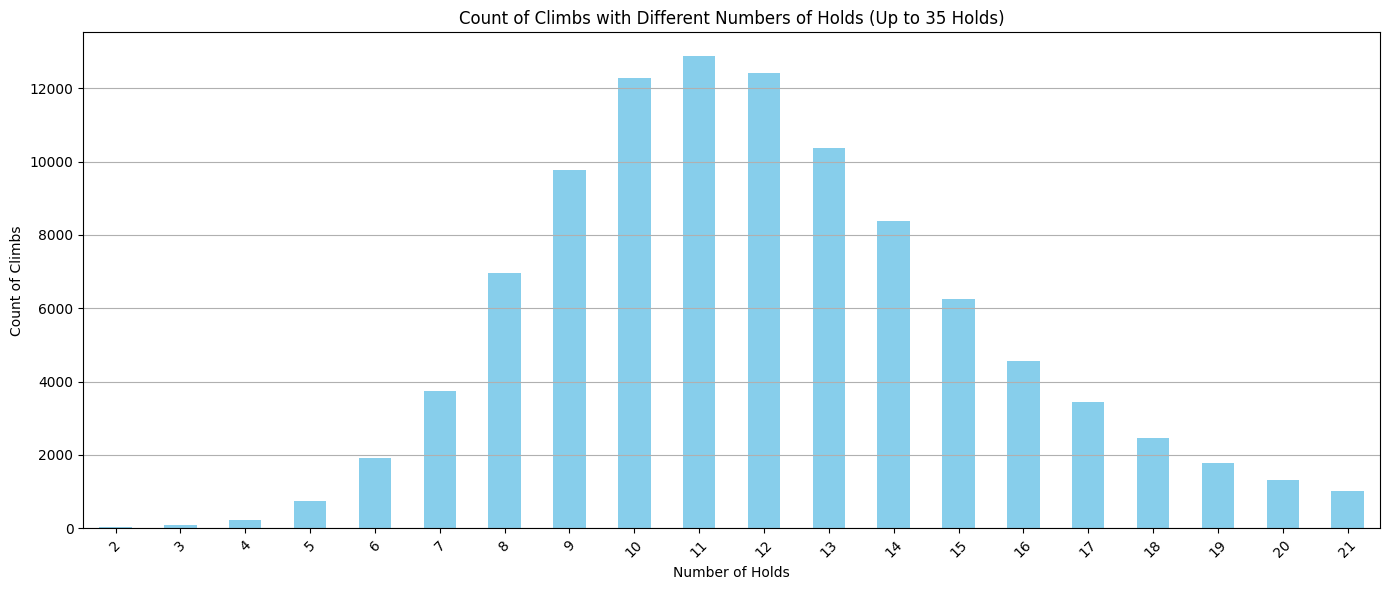

Average Number of Holds: 11.952696996492762


In [65]:
# plot_vgrade_counts(filtered_df)
plot_hold_counts(filtered_df)
# average_starting_hold_height, percentage_with_starting_holds_at_35 = analyze_starting_hold_heights(filtered_df)
# print_unique_climbs_count(filtered_df)


### Create Text File

In [66]:
filtered_df = filter_climbs(filtered_df, vgrade=-1, angle=-1)
filtered_df['frames'] = filtered_df['frames'].apply(sort_frame)
filtered_df_to_text_file(filtered_df, file_path='climbs.txt')



file_path = 'climbs.txt'

# def print_unique_words(file_path):
#     word_counts = count_unique_words(file_path)
#     if word_counts:
#         sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[0], reverse=True)
#         for word, count in sorted_word_counts:
#             print(word, count)


In [67]:
# frame = "p1476r15p1152r12p1172r12p1504r15p1200r13p1230r13p1252r13p1319r13p1335r13p1387r14p1165r15p1511r15p1216r13"
# frame_to_image(frame)

### Markov Chain Model

Successfully Trained
Valid Sequence: 1476r15 1128r12 1483r15 1144r15 1156r15 1189r12 1206r15 1236r13 1268r13 1322r13 1354r13 1387r14 1081r15
[(236, 847.0, 5), (213, 826, 2), (18, 805.0, 5), (171, 784, 5), (675, 784, 5), (633, 700, 2), (633, 658, 5), (465, 574, 3), (381, 490, 3), (507, 364, 3), (423, 280, 3), (381, 196, 4), (388, 955, 5)]


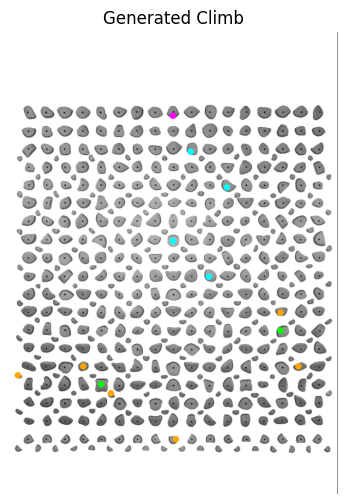

In [97]:
m = Markov(file_path='climbs.txt')
chain = m.model

valid_sequence = predict_valid_sequence(chain, '1476r15', number_of_words=13)
def frame_to_image(frame):
    image_path = "KilterBoardSetup.png"
    coords_list = frame_to_imagecoords(frame)
    print(coords_list)
    draw_colored_circles_on_image(image_path, coords_list)
print("Valid Sequence:", valid_sequence)
generated_frame = 'p' + valid_sequence.replace(' ', 'p')
frame_to_image(generated_frame)

# r12 - starthold  
# r13 - hand hold  
# r14 - finish hold 
# r15 - foot hold   


In [69]:
def ids_to_coordinates():
    # Iterate through the first range: 1073-1395
    for id in range(1073, 1396):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")
    
    # Iterate through the second range: 1447-1599
    for id in range(1447, 1600):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")

ids_to_coordinates()

### Prepare Data into npz file ###

In [79]:
def get_hold_vector(row, col):
    if 34 - row >  34 or col > 34:
        if row > col:
            raise ValueError(f"Row index {row} exceeds maximum allowed value of 34.")
        else:
            raise ValueError(f"Column index {col} exceeds maximum allowed value of 34.")
    
    if max(hold_directions[34 - row][col]) > 1:
        index = int(hold_directions[34 - row][col][0]) - 1
        hold_direction = hold_directions2[index].tolist()
    else:
        hold_direction = hold_directions[34 - row][col].tolist()
    
    hold_magnitude = hold_magnitudes[34 - row][col][0]
    
    return hold_direction, hold_magnitude

# hold_direction, hold_magnitude = get_hold_vector(row, col)

def unit_vector_to_sin(vector):
    x, y = vector
    angle_radians = np.arctan2(y, x)
    sin_value = np.sin(angle_radians)
    return sin_value

def unit_vector_to_cos(vector):
    x, y = vector
    angle_radians = np.arctan2(y, x)
    cos_value = np.cos(angle_radians)
    return cos_value

def modified_hold_quality(climb_angle, hold_quality):
    climb_angle_radians = np.deg2rad(climb_angle)
    modified_quality = np.cos(climb_angle_radians * hold_quality)
    return modified_quality

def interhold_angle(a, b):
    x1, y1 = a
    x2, y2 = b
    angle_radians = np.arctan2(y2 - y1, x2 - x1)
    return angle_radians

def average_unit_vectors(vectors):
    if len(vectors) == 1:
        return vectors[0]
    elif len(vectors) == 2:
        avg_x = (vectors[0][0] + vectors[1][0]) / 2
        avg_y = (vectors[0][1] + vectors[1][1]) / 2
        norm = np.sqrt(avg_x**2 + avg_y**2)
        return [avg_x / norm, avg_y / norm]
    else:
        raise ValueError("The input should be a list containing one or two unit vectors.")
    
def climb_to_tupleslist(row):
    frames = row['frames']
    climb_angle = row['angle_y']
    climb_difficulty = map_vgrade(row['display_difficulty'])

    triplets = frame_to_triplets(frames)
    feature_tuples = []

    for i, (x, y, val) in enumerate(triplets):
        hold_direction, hold_quality = get_hold_vector(y, x)
        
        # Check if hold_direction is a list of lists and average if necessary
        if isinstance(hold_direction[0], list):  
            hold_direction = average_unit_vectors(hold_direction)

        hold_angle = unit_vector_to_cos(hold_direction)
        modified_quality = modified_hold_quality(climb_angle, hold_quality)
        
        if i < len(triplets) - 1:
            next_x, next_y, _ = triplets[i + 1]
            inter_hold_angle = np.sin(interhold_angle((x, y), (next_x, next_y)))
        else:
            inter_hold_angle = 0  # Last hold doesn't have a next hold
        
        feature_tuple = (y, x, val- 2 , hold_angle, hold_quality, modified_quality, inter_hold_angle, climb_angle, climb_difficulty)
        
        # Validate feature_tuple elements
        for j, feature in enumerate(feature_tuple):
            if not isinstance(feature, (int, float)):
                raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")

        # Ensure feature_tuple has exactly 9 elements
        if len(feature_tuple) != 9:
            raise ValueError(f"Feature tuple length is incorrect: {len(feature_tuple)}")
        
        feature_tuples.append(feature_tuple)
    
    return feature_tuples

# def df_to_npz(df, filename, num_climbs=None, random_climbs=False):
#     climb_matrices = {}

#     if num_climbs is not None and num_climbs != "all":
#         if random_climbs:
#             df = df.sample(n=num_climbs)
#         else:
#             df = df.head(num_climbs)

#     for idx, row in df.iterrows():
#         climb_name = row['name']
#         feature_tuples = climb_to_tupleslist(row)

#         matrix = np.array([list(t) for t in feature_tuples])
#         climb_matrices[climb_name] = matrix

#     np.savez_compressed(filename, **climb_matrices)

def df_to_npz(df, filename, num_climbs=None, random_climbs=False):
    climb_matrices = {}
    max_length = 21  # Maximum desired length for each climb matrix

    if num_climbs is not None and num_climbs != "all":
        if random_climbs:
            df = df.sample(n=num_climbs)
        else:
            df = df.head(num_climbs)

    for idx, row in df.iterrows():
        climb_name = row['name']
        feature_tuples = climb_to_tupleslist(row)

        matrix = np.array([list(t) for t in feature_tuples])

        # Calculate current matrix length
        current_length = matrix.shape[0]
        
        # Pad matrix if it's shorter than max_length
        if current_length < max_length:
            pad_length = max_length - current_length
            padded_matrix = np.vstack([matrix, np.zeros((pad_length, matrix.shape[1]))])
        else:
            padded_matrix = matrix[:max_length, :]  # Trim if longer than max_length
        
        climb_matrices[climb_name] = padded_matrix

    np.savez_compressed(filename, **climb_matrices)

df_to_npz(filtered_df, 'climb_matrices.npz', num_climbs=30000, random_climbs=True)


def load_npz(file):
    data = np.load(file, allow_pickle=True)
    matrices = {key: data[key] for key in data}
    return matrices

def calculate_global_stats(matrices):
    all_data = np.concatenate([matrix for matrix in matrices.values()])
    global_means = np.mean(all_data, axis=0)
    global_stds = np.std(all_data, axis=0)

    # Avoid division by zero
    global_stds[global_stds == 0] = 1

    return global_means, global_stds


def standardize_matrix(matrix, global_means, global_stds):
    standardized_matrix = (matrix - global_means) / global_stds
    return standardized_matrix

# def standardize_npz(input_file, output_file):
#     matrices = load_npz(input_file)
#     global_means, global_stds = calculate_global_stats(matrices)
#     print(global_means)
    
#     standardized_matrices = {}
#     for climb_name, matrix in matrices.items():
#         standardized_matrix = standardize_matrix(matrix, global_means, global_stds)
#         standardized_matrices[climb_name] = standardized_matrix
    
#     np.savez_compressed(output_file, **standardized_matrices)

def standardize_npz(input_file, output_file):## with padding for mlp consistent iinput sizes
    matrices = load_npz(input_file)
    global_means, global_stds = calculate_global_stats(matrices)
    
    standardized_matrices = {}
    max_length = 21  # Maximum desired length for each climb matrix
    
    for climb_name, matrix in matrices.items():
        # Calculate current matrix length
        current_length = matrix.shape[0]
        
        # Pad matrix if it's shorter than max_length
        if current_length < max_length:
            pad_length = max_length - current_length
            padded_matrix = np.vstack([matrix, np.zeros((pad_length, matrix.shape[1]))])
        else:
            padded_matrix = matrix[:max_length, :]  # Trim if longer than max_length
        
        # Standardize the padded_matrix
        standardized_matrix = standardize_matrix(padded_matrix, global_means, global_stds)
        
        # Store standardized matrix in dictionary
        standardized_matrices[climb_name] = standardized_matrix
    
    np.savez_compressed(output_file, **standardized_matrices)
    return global_means, global_stds

# Example usage:
global_means, global_stds = standardize_npz('climb_matrices.npz', 'standardized_climb_matrices.npz')


### MLP Model ###

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ClimbDataset(Dataset):
    def __init__(self, npz_file):
        self.data = np.load(npz_file, allow_pickle=True)
        self.climb_names = list(self.data.keys())
        self.num_climbs = len(self.climb_names)
    
    def __len__(self):
        return self.num_climbs
    
    def __getitem__(self, idx):
        climb_name = self.climb_names[idx]
        climb_matrix = self.data[climb_name]
        return climb_matrix

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        # Shared layers
        self.fc_shared1 = nn.Linear(9, 64)
        self.fc_shared2 = nn.Linear(64, 32)
        
        # Task-specific layers
        self.fc_row = nn.Linear(32, 1)  # Output layer for row prediction
        self.fc_col = nn.Linear(32, 1)  # Output layer for col prediction
        self.fc_val = nn.Linear(32, 1)  # Output layer for val prediction
        
    def forward(self, x):
        x = F.relu(self.fc_shared1(x))
        x = F.relu(self.fc_shared2(x))
        
        # Task-specific paths
        row_pred = self.fc_row(x)
        col_pred = self.fc_col(x)
        val_pred = self.fc_val(x)
        
        return row_pred, col_pred, val_pred

# Load your dataset
dataset = ClimbDataset('climb_matrices.npz')

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model and move it to GPU if available
model = MLP().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Use MSE loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10  # Example: Train for 10 epochs

# Lists to store loss values
train_losses_row = []
train_losses_col = []
train_losses_val = []
val_losses_row = []
val_losses_col = []
val_losses_val = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss_row = 0.0
    running_train_loss_col = 0.0
    running_train_loss_val = 0.0
    
    # Iterate over data
    for climbs in train_loader:
        climbs = climbs[0].to(device)  # Move data to GPU if available
        num_tuples = len(climbs)
        
        # Accumulate gradients for each batch
        optimizer.zero_grad()
        batch_loss_row = 0.0
        batch_loss_col = 0.0
        batch_loss_val = 0.0
        
        # Iterate through tuples to predict next tuple's first 3 features
        for i in range(num_tuples - 1):
            current_tuple = climbs[i][:9].clone().detach().float()
            next_tuple_first3 = climbs[i + 1][:3].clone().detach().float()

            # Forward pass
            pred_row, pred_col, pred_val = model(current_tuple)
            
            # Compute losses
            loss_row = criterion(pred_row, next_tuple_first3[0].unsqueeze(0))
            loss_col = criterion(pred_col, next_tuple_first3[1].unsqueeze(0))
            loss_val = criterion(pred_val, next_tuple_first3[2].unsqueeze(0))

            # Accumulate total batch loss
            batch_loss_row += loss_row
            batch_loss_col += loss_col
            batch_loss_val += loss_val
        
        # Backward pass and optimize
        batch_loss = batch_loss_row + batch_loss_col + batch_loss_val
        batch_loss.backward()
        optimizer.step()

        running_train_loss_row += batch_loss_row.item()
        running_train_loss_col += batch_loss_col.item()
        running_train_loss_val += batch_loss_val.item()
    
    # Compute average training losses
    avg_train_loss_row = running_train_loss_row / len(train_loader)
    avg_train_loss_col = running_train_loss_col / len(train_loader)
    avg_train_loss_val = running_train_loss_val / len(train_loader)
    train_losses_row.append(avg_train_loss_row)
    train_losses_col.append(avg_train_loss_col)
    train_losses_val.append(avg_train_loss_val)

    # Validation loop
    model.eval()
    running_val_loss_row = 0.0
    running_val_loss_col = 0.0
    running_val_loss_val = 0.0
    with torch.no_grad():
        for climbs in val_loader:
            climbs = climbs[0].to(device)  # Move data to GPU if available
            num_tuples = len(climbs)
            for i in range(num_tuples - 1):
                current_tuple = climbs[i][:9].clone().detach().float()
                next_tuple_first3 = climbs[i + 1][:3].clone().detach().float()

                # Forward pass
                pred_row, pred_col, pred_val = model(current_tuple)

                # Compute losses
                loss_row = criterion(pred_row, next_tuple_first3[0].unsqueeze(0))
                loss_col = criterion(pred_col, next_tuple_first3[1].unsqueeze(0))
                loss_val = criterion(pred_val, next_tuple_first3[2].unsqueeze(0))

                running_val_loss_row += loss_row.item()
                running_val_loss_col += loss_col.item()
                running_val_loss_val += loss_val.item()

    # Compute average validation losses
    avg_val_loss_row = running_val_loss_row / len(val_loader)
    avg_val_loss_col = running_val_loss_col / len(val_loader)
    avg_val_loss_val = running_val_loss_val / len(val_loader)
    val_losses_row.append(avg_val_loss_row)
    val_losses_col.append(avg_val_loss_col)
    val_losses_val.append(avg_val_loss_val)

    # Print statistics
    print(f'Epoch {epoch + 1}, Training Loss (Row): {avg_train_loss_row}, Validation Loss (Row): {avg_val_loss_row}')
    print(f'Epoch {epoch + 1}, Training Loss (Col): {avg_train_loss_col}, Validation Loss (Col): {avg_val_loss_col}')
    print(f'Epoch {epoch + 1}, Training Loss (Val): {avg_train_loss_val}, Validation Loss (Val): {avg_val_loss_val}')

print('Finished Training')

# Plot training and validation losses for each task
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.plot(range(1, num_epochs + 1), train_losses_row, label='Training Loss (Row)')
plt.plot(range(1, num_epochs + 1), val_losses_row, label='Validation Loss (Row)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Row Prediction Training and Validation Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(1, num_epochs + 1), train_losses_col, label='Training Loss (Col)')
plt.plot(range(1, num_epochs + 1), val_losses_col, label='Validation Loss (Col)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Col Prediction Training and Validation Loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(range(1, num_epochs + 1), train_losses_val, label='Training Loss (Val)')
plt.plot(range(1, num_epochs + 1), val_losses_val, label='Validation Loss (Val)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Val Prediction Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Code for Generating MLP climbs/Tuple Lists ###

In [ ]:
def hold_to_tuple(hold, interhold_angle, climb_angle, climb_difficulty):
    # Convert the hold string to triplets (it will return a list with a single triplet)
    triplet = frame_to_triplets(hold)[0]
    x, y, val = triplet
    
    # Get hold direction and hold quality
    hold_direction, hold_quality = get_hold_vector(y, x)
    
    # Check if hold_direction is a list of lists and average if necessary
    if isinstance(hold_direction[0], list):
        hold_direction = average_unit_vectors(hold_direction)

    hold_angle = unit_vector_to_cos(hold_direction)
    modified_quality = modified_hold_quality(climb_angle, hold_quality)
    
    feature_tuple = (y, x, val - 2, hold_angle, hold_quality, modified_quality, interhold_angle, climb_angle, climb_difficulty)
    
    # Validate feature_tuple elements
    for j, feature in enumerate(feature_tuple):
        if not isinstance(feature, (int, float)):
            raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")

    # Ensure feature_tuple has exactly 9 elements
    if len(feature_tuple) != 9:
        raise ValueError(f"Feature tuple length is incorrect: {len(feature_tuple)}")
    
    return feature_tuple

# Example usage
hold = "p1127r12"  # Example hold string
interhold_angle = 0.5
climb_angle = 45
climb_difficulty = 5  # Example difficulty

hold_tuple = hold_to_tuple(hold, interhold_angle, climb_angle, climb_difficulty)
# print(hold_tuple)

import numpy as np

def random_angle_to_sin():
    angle = np.random.uniform(0, 180)
    sin_value = np.sin(np.deg2rad(angle))
    return sin_value

def inverse_standardize_matrix(standardized_matrix, global_means, global_stds):
    unnormalized_matrix = (standardized_matrix * global_stds) + global_means
    return unnormalized_matrix
def inverse_standardize_tuple(feature_tuple, global_means, global_stds):
    # Perform inverse standardization for the first 3 features (x, y, val)
    unstandardized_tuple = []
    for i in range(3):
        unstandardized_value = (feature_tuple[i] * global_stds[i]) + global_means[i]
        unstandardized_tuple.append(unstandardized_value)
    return tuple(unstandardized_tuple)

def generate_climb(mlp_model, climb_difficulty, climb_angle, starting_hold, num_holds):
    climb_matrix = []

    # Initialize current hold
    current_hold = frame_to_triplets(starting_hold)[0]
    current_hold_unstandardized = inverse_standardize_tuple(current_hold, global_means, global_stds)
    current_hold_unstandardized = tuple(int(round(num)) for num in current_hold_unstandardized)
    for _ in range(num_holds):
        # Generate random sin value for the interhold angle
        interhold_angle = random_angle_to_sin()
        
        # Get hold vector and quality for the current hold
        hold_direction, hold_quality = get_hold_vector(current_hold_unstandardized[0], current_hold_unstandardized[1])
        if isinstance(hold_direction[0], list):  
            hold_direction = average_unit_vectors(hold_direction)
        hold_angle = unit_vector_to_cos(hold_direction)
        modified_quality = modified_hold_quality(climb_angle, hold_quality)
        
        # Prepare the feature tuple
        feature_tuple = (current_hold[0], current_hold[1], current_hold[2], hold_angle, hold_quality, modified_quality, interhold_angle, climb_angle, climb_difficulty)
        
        # Append the feature tuple to the climb matrix
        climb_matrix.append(feature_tuple)
        
        # Convert feature_tuple to tensor and move to the same device as the model
        feature_tensor = torch.tensor([feature_tuple], dtype=torch.float32).to(device)
        mlp_model = mlp_model.to(torch.device("cuda"))
        next_hold_tensor = mlp_model(feature_tensor)
        
        
        # Convert the prediction tensor to a numpy array and extract the next hold
        next_hold = (next_hold_tensor[0].detach().cpu().numpy()[0][0], next_hold_tensor[1].detach().cpu().numpy()[0][0], next_hold_tensor[2].detach().cpu().numpy()[0][0])
        print(next_hold)
        
        current_hold = next_hold

    return climb_matrix

def generate_climb_unstandardized(mlp_model, climb_difficulty, climb_angle, starting_hold, num_holds):
    climb_matrix = []

    # Initialize current hold
    current_hold = frame_to_triplets(starting_hold)[0]
    current_hold_rounded = tuple(int(round(num)) for num in current_hold)
    for _ in range(num_holds):
        # Generate random sin value for the interhold angle
        interhold_angle = random_angle_to_sin()
        
        # Get hold vector and quality for the current hold
        hold_direction, hold_quality = get_hold_vector(current_hold_rounded[0], current_hold_rounded[1])
        if isinstance(hold_direction[0], list):  
            hold_direction = average_unit_vectors(hold_direction)
        hold_angle = unit_vector_to_cos(hold_direction)
        modified_quality = modified_hold_quality(climb_angle, hold_quality)
        
        # Prepare the feature tuple
        feature_tuple = (current_hold[0], current_hold[1], current_hold[2], hold_angle, hold_quality, modified_quality, interhold_angle, climb_angle, climb_difficulty)
        
        # Append the feature tuple to the climb matrix
        climb_matrix.append(feature_tuple)
        
        # Convert feature_tuple to tensor and move to the same device as the model
        feature_tensor = torch.tensor([feature_tuple], dtype=torch.float32).to(device)
        mlp_model = mlp_model.to(torch.device("cuda"))
        next_hold_tensor = mlp_model(feature_tensor)
        
        
        # Convert the prediction tensor to a numpy array and extract the next hold
        next_hold = (next_hold_tensor[0].detach().cpu().numpy()[0][0], next_hold_tensor[1].detach().cpu().numpy()[0][0], next_hold_tensor[2].detach().cpu().numpy()[0][0])
        print(next_hold)
        
        current_hold = next_hold

    return climb_matrix

climb_difficulty = 5
climb_angle = 45
starting_hold = "p1127r12"
num_holds = 12

generated_climb = generate_climb_unstandardized(model, climb_difficulty, climb_angle, starting_hold, num_holds)
# generated_climb = generate_climb(model, climb_difficulty, climb_angle, starting_hold, num_holds)
print(type(generated_climb))


In [ ]:
def coords_to_image(coords_list):
    image_path = "KilterBoardSetup.png"
    draw_colored_circles_on_image(image_path, coords_list)
coords_to_image(generated_climb)

In [76]:
# show(filtered_df)
print(torch.cuda.is_available())

True
